# RM for OBC data redatuming

In [1]:
# env: UD_RM
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp2d
from scipy.signal import convolve, filtfilt
from scipy.sparse.linalg import lsqr
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.waveeqprocessing.marchenko import directwave
from pylops.optimization.leastsquares  import *

from pylops.waveeqprocessing.kirchhoff import Kirchhoff

## Inputs

In [2]:
inputfile = '../dataset/volve_imaging_full_fmax30_shift.npz' 
inputdata = np.load(inputfile)
inputdata.files

['Pd', 'Pu', 'r', 's', 'vel', 't', 'x', 'z']

In [3]:
tsoff = 0.02         # direct arrival time shift source side
troff = 0.02         # direct arrival time shift receiver side
nsmooth = 10         # time window smoothing
nfmax = 800          # max frequency for MDC (#samples)
niter = 10           # iterations
convolvedata = False  # apply convolution to data
igaths = [41, 61,
          81, 101,
          121]        # indeces of angle gathers
nalpha = 61          # number of angles in Angle gathers

# igaths = [1, 2, 3]        # indeces of angle gathers
# nalpha = 2          # number of angles in Angle gathers

inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
nr = r.shape[1]
dr = np.mean(np.abs(np.diff(r[0])))

# Sources
s = inputdata['s']
ns = s.shape[1]
ds = np.mean(np.abs(np.diff(s[0])))

# Density model
vel = inputdata['vel']
z, x = inputdata['z'], inputdata['x']
nz, nx = z.shape[0], x.shape[0]
dz, dx = np.mean(np.diff(z)), np.mean(np.diff(x))

# Time axis
t = inputdata['t']
ot, dt, nt = t[0], t[1]-t[0], len(t)


# Wavefield data 
Pu = inputdata['Pu'] #should be (r,s,t)
Pd = inputdata['Pd']
# Puo = inputdata['Puo']


In [8]:
wav, _, wav_c = ricker(t[0:61], 15)
wav = wav / np.max(np.abs(np.fft.fft(wav))*dt) 
wav_c = np.argmax(wav)

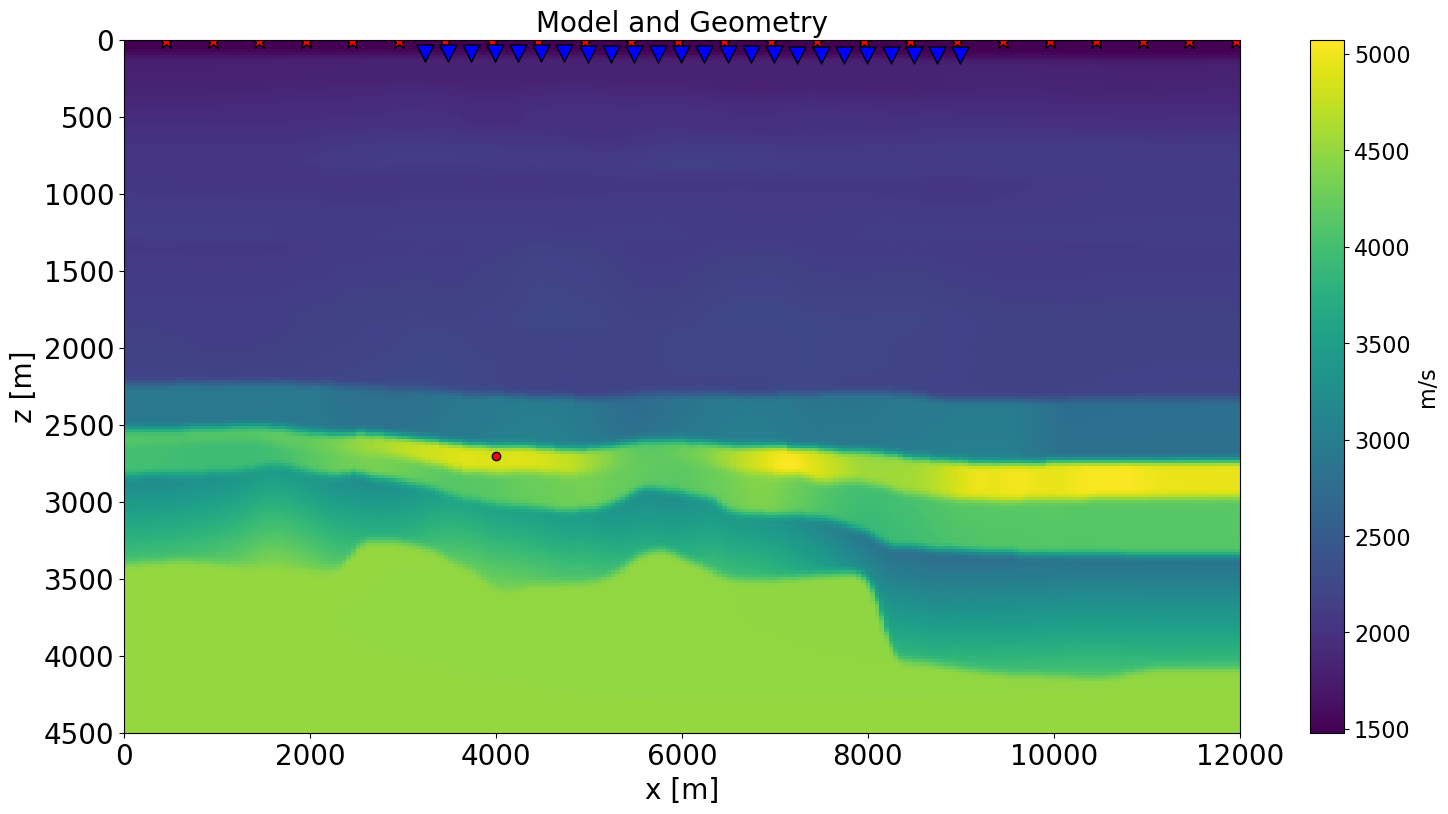

In [9]:
vs=(x[80],z[135])        #visual source

plt.figure(figsize=(18,9))
h=plt.imshow(vel, extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, ::10], s[1, ::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]',fontsize=20),plt.ylabel('z [m]',fontsize=20),plt.title('Model and Geometry',fontsize=20)
plt.xticks(fontsize=20),plt.yticks(fontsize=20)
plt.colorbar(h,label="m/s")
plt.xlim(x[0], x[-1]);

(8996.031414511148, 3012.4324554347013, 5.998, 0.0)

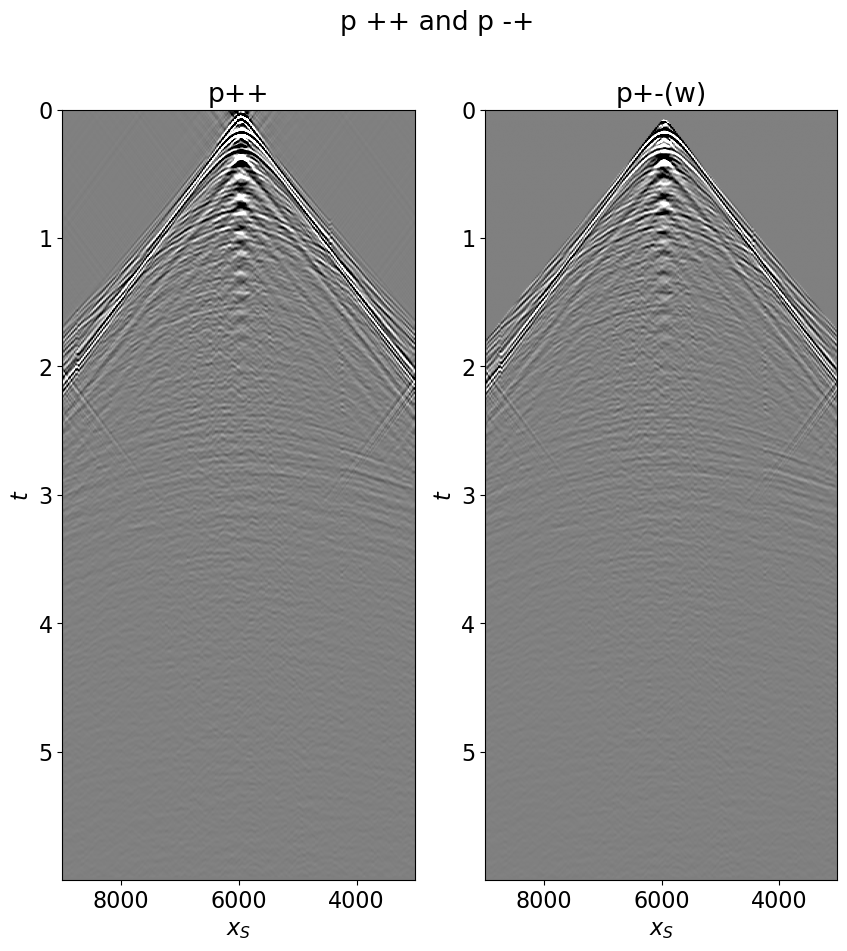

In [10]:
clip = 0.03
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
fig.suptitle('p ++ and p -+')
axs[0].imshow(Pd[:,ns//2].T, cmap='gray', vmin=-clip*np.abs(Pu+Pd).max(), 
              vmax=clip*np.abs(Pu+Pd).max(), extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('p++'), axs[0].set_xlabel(r'$x_S$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
# axs[0].set_ylim(4, 0);
axs[1].imshow(Pu[:,ns//2].T, cmap='gray', vmin=-clip*np.abs(Pu+Pd).max(), 
              vmax=clip*np.abs(Pu+Pd).max(), extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('p+-(w)'), axs[1].set_xlabel(r'$x_S$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
# axs[1].set_ylim(4, 0);

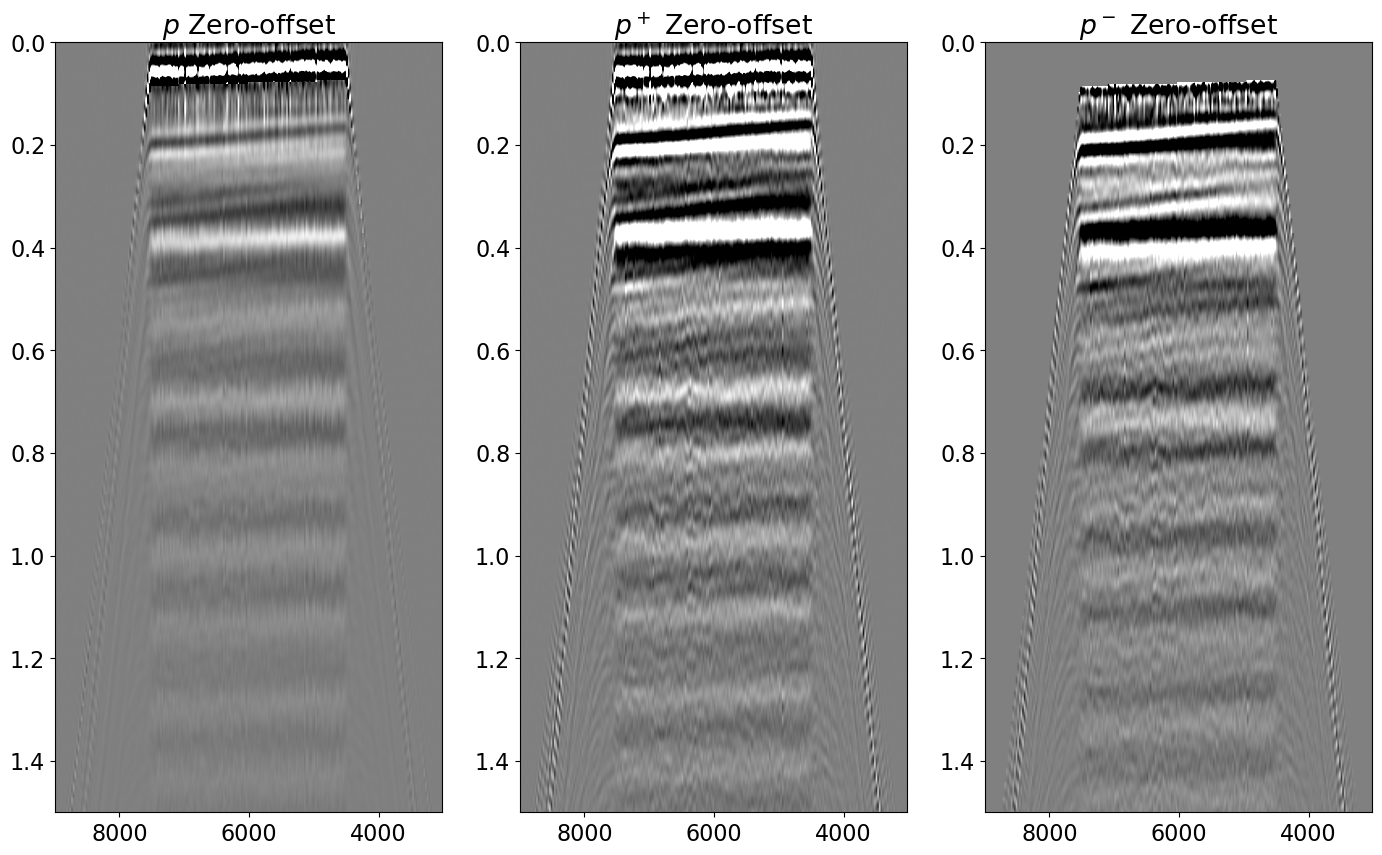

In [11]:
pup = Pu.transpose(1, 2, 0)    # organized as  (r, s, t)->(s, t, r)
pdown = Pd.transpose(1, 2, 0)  # organized as  (r, s, t)->(s, t, r)
p = pup+pdown
clip=0.1

p_zo = np.zeros((ns, nt))
pup_zo = np.zeros((ns, nt))
pdown_zo = np.zeros((ns, nt))

for isrc in range(ns):
    irec_zo = np.argmin(np.abs(s[0, isrc]-r[0]))
    p_zo[isrc] = p[isrc, :, irec_zo]
    pup_zo[isrc], pdown_zo[isrc] = pup[isrc, :, irec_zo], pdown[isrc, :, irec_zo]
    
fig, axs = plt.subplots(1, 3, figsize=(17,10))
axs[0].imshow(p_zo.T, cmap='gray', vmin=-clip*np.abs(p_zo).max(), vmax=clip*np.abs(p_zo).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$p$ Zero-offset')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(pdown_zo.T, cmap='gray', vmin=-clip*np.abs(p_zo).max(), vmax=clip*np.abs(p_zo).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$p^+$ Zero-offset')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0)
axs[2].imshow(pup_zo.T, cmap='gray', vmin=-clip*np.abs(p_zo).max(), vmax=clip*np.abs(p_zo).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title(r'$p^-$ Zero-offset')
axs[2].axis('tight')
axs[2].set_ylim(1.5, 0);

## MDD

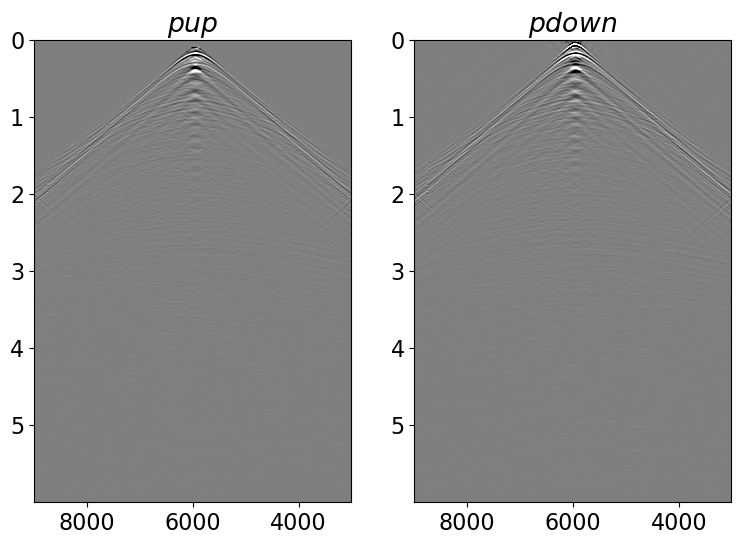

In [12]:
# Pad data with zero at the end (to avoid wrap around)
npad = 50
pdown = np.pad(pdown, ((0, 0), (0, npad), (0, 0))).astype('float32')
pup = np.pad(pup, ((0, 0), (0, npad), (0, 0))).astype('float32')
ntpad = pup.shape[1]

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup[nr//2], cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown[nr//2], cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight');

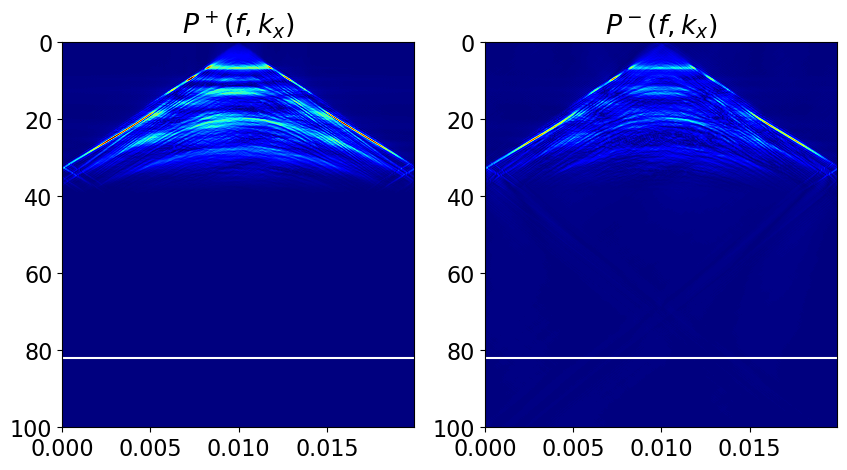

In [13]:
# check max frequency to use
nfmax=500
nfft = ntpad

FFTop = FFT2D(dims=[nr, ntpad], nffts=[nfft, nfft], sampling=[dr, dt])
PUP = (FFTop*pup[ns//2].T.flatten()).reshape(nfft, nfft)
PDOWN = (FFTop*pdown[ns//2].T.flatten()).reshape(nfft, nfft)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(PDOWN[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[0].axhline(FFTop.f2[nfmax], color='w')
axs[0].set_title(r'$P^+(f, k_x)$')
axs[0].axis('tight')
axs[0].set_ylim(100, 0);
im=axs[1].imshow(np.fft.fftshift(np.abs(PUP[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[1].axhline(FFTop.f2[nfmax], color='w')
axs[1].set_title(r'$P^-(f, k_x)$')
axs[1].axis('tight');
axs[1].set_ylim(100, 0);              

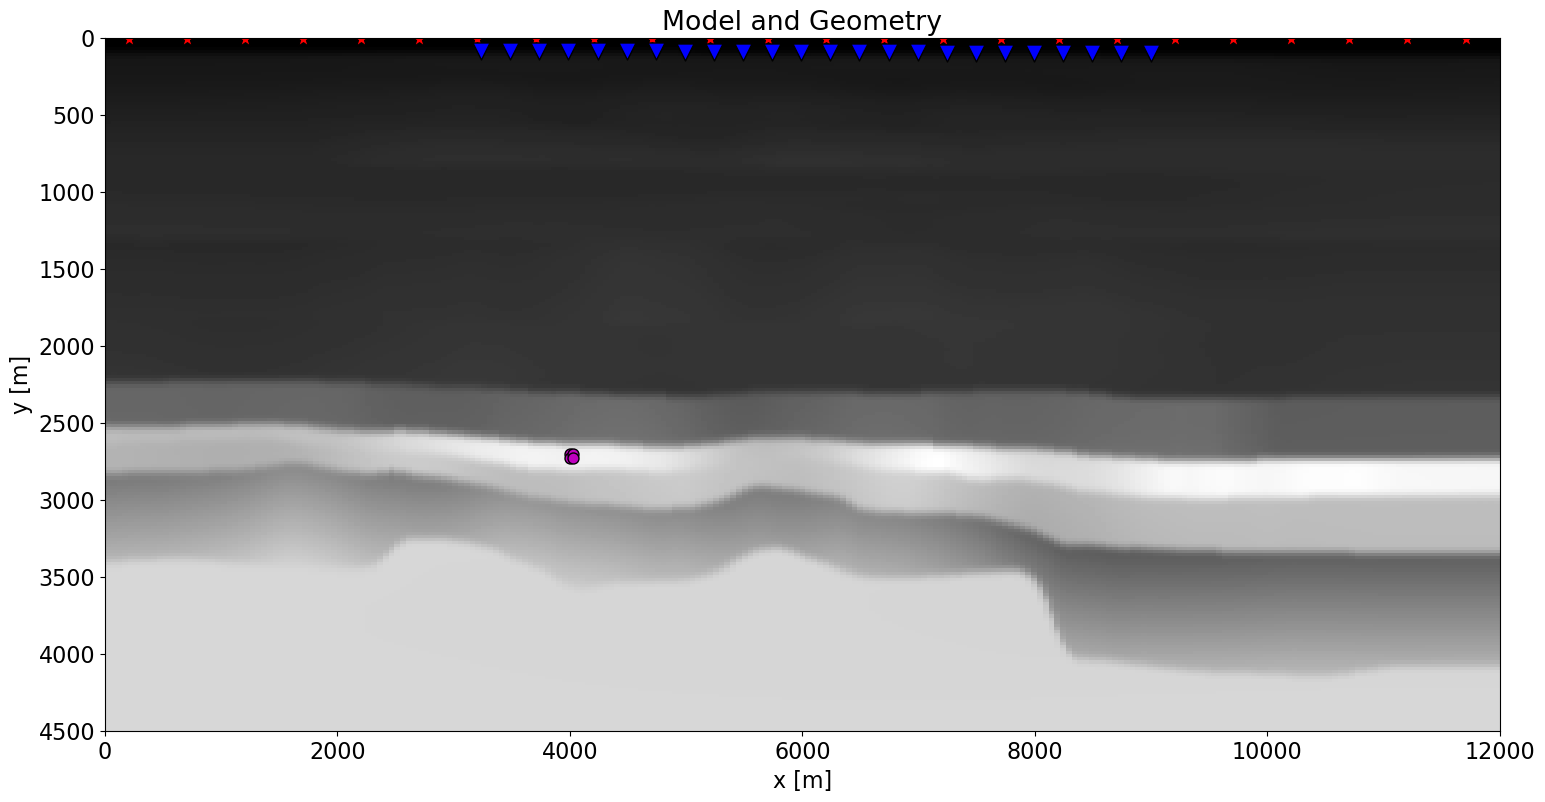

In [15]:
# Imaging domain
nvsx, nvsz = 2, 2
dvsx, dvsz = 25, 30
vsx = np.arange(nvsx)*dvsx + vs[0]
vsz = np.arange(nvsz)*dvsz + vs[1]
VSX, VSZ = np.meshgrid(vsx, vsz, indexing='ij')

plt.figure(figsize=(18,9))
plt.imshow(vel, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(VSX.ravel(), VSZ.ravel(), marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

In [16]:
# Create interpolation function
interp_func = interp2d(np.arange(vel.shape[1]),
                       np.arange(vel.shape[0]),
                       vel,
                       kind='linear')

# Interpolate to the new dimensions
new_vel = interp_func(np.linspace(0, vel.shape[1] - 1, 2*vel.shape[1] - 1),
                      np.linspace(0, vel.shape[0] - 1, 2*vel.shape[0] - 1))
# new_vel = interp_func(np.linspace(0, vel.shape[1] - 1, 2401),
#                       np.linspace(0, vel.shape[0] - 1, 901))

In [17]:
nx = new_vel.shape[1]
nz = new_vel.shape[0]

z = np.linspace(0, 4500, nz, dtype=int)
x = np.linspace(0, 12000, nx, dtype=int)

dz = z[1] - z[0]
dx = x[1] - x[0]

In [ ]:
# para for pick (nvsx,nvsz,nr) 
nx = x.size
nz = z.size
vsx_o = int(vsx[0]/dx+1)
vsz_o = int(vsz[0]/dz)
vsx_interval = int(dvsx/dx)
vsz_interval = int(dvsz/dz)
vsx_e = int(vsx[-1]/dx+2)
vsz_e = int(vsz[-1]/dz+1)

# vel, z ,r for computing direct arrival from vs to mirror receiver
dvel_flipud = int(np.ceil(np.max(r[1])/dz))
deltvel = new_vel[0:dvel_flipud]
vel_mr = np.vstack((deltvel, new_vel))

deltz = -np.flipud(z[0:dvel_flipud])-dz
z_mr = np.hstack((deltz, z))
nz_mr = z_mr.size

zr_mr = -r[1,:]
r_mr = np.vstack((r[0,:], zr_mr))

# direct arrival from vs to mirror receiver
trav_srcs_mr, trav_recs_mr, _, _, _, _ = Kirchhoff._traveltime_table(z_mr, x, s, r_mr, vel_mr.T, mode='eikonal')

trav_s_mr   = trav_srcs_mr.reshape(nx * nz_mr, ns) 
trav_s      = trav_s_mr.reshape(nx, nz_mr, ns) 
trav_s_arr  = trav_s[:,-nz:,:]

trav_r_mr   = trav_recs_mr.reshape(nx * nz_mr, nr) 
trav_mr     = trav_r_mr.reshape(nx, nz_mr, nr) 
trav_mr_arr = trav_mr[:,-nz:,:]

# para for picking virtual sources to sources and mirror receivers
trav_mr1 = trav_mr_arr[vsx_o:vsx_e,vsz_o:vsz_e,:]
trav_mr2 = trav_mr1[::vsx_interval,::vsz_interval,:]

trav_s1 = trav_s_arr[vsx_o:vsx_e,vsz_o:vsz_e,:]
trav_s2 = trav_s1[::vsx_interval,::vsz_interval,:]


In [19]:
# window VS-R
FirstVSr = trav_mr2[0,0,:]
FirstVSr_off = FirstVSr - troff

iFirstVSr_off = np.round(FirstVSr_off/dt).astype(np.int64)
wr = np.zeros((nr, nt))

for ir in range(nr):
    wr[ir, :iFirstVSr_off[ir]]=1

wr = np.hstack((np.fliplr(wr), wr[:, 1:]))


In [20]:
# window VSS
FirstVSs = trav_s2[0,0,:]
FirstVSs_off = FirstVSs - tsoff

iFirstVSs_off = np.round(FirstVSs_off/dt).astype(np.int64)
ws = np.zeros((ns, nt))

for ir in range(ns):
    ws[ir, :iFirstVSs_off[ir]]=1
    
ws = np.hstack((np.fliplr(ws), ws[:, 1:]))

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    wr  = filtfilt(smooth, 1, wr)
    ws  = filtfilt(smooth, 1, ws)

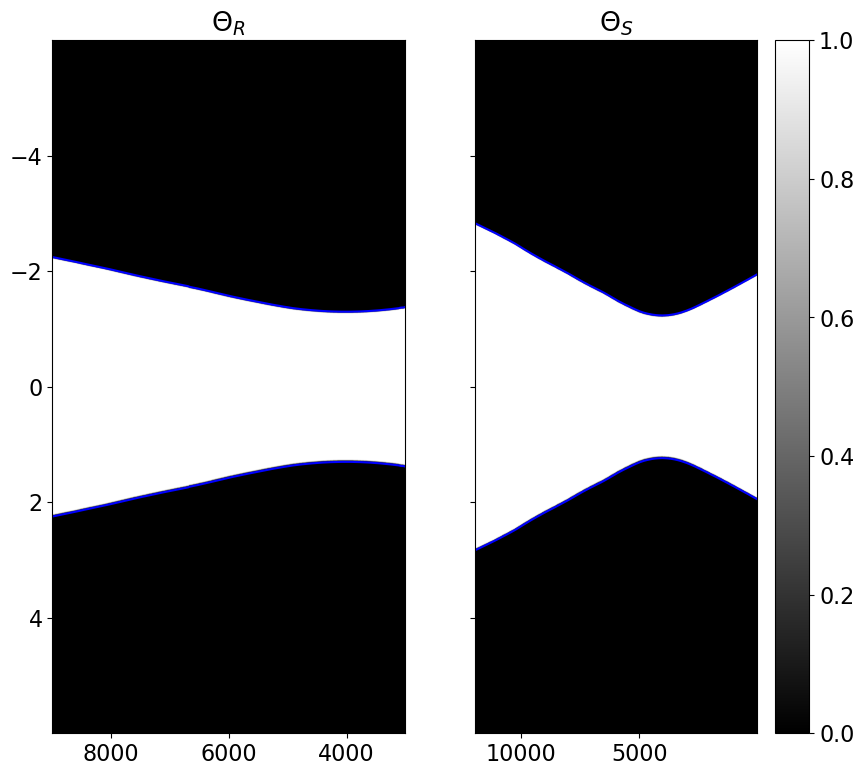

In [21]:
fig, ax = plt.subplots(1, 2,  sharey=True, figsize=(10, 9))
ax[0].imshow(wr.T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax[0].plot(r[0], FirstVSr,'b'),ax[0].plot(r[0], -FirstVSr,'b')
ax[0].set_title(r'$\Theta_R$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax[0].axis('tight')
im=ax[1].imshow(ws.T, cmap='gray', extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
ax[1].plot(s[0], FirstVSs,'b'),ax[1].plot(s[0], -FirstVSs,'b')
ax[1].set_title(r'$\Theta_S$'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
ax[1].axis('tight')

fig.colorbar(im,ax=ax[1]);

## Inversion

In [22]:
nfmax = 300          # max frequency for MDC (#samples)
# Add negative time to Pu operators
Putwosided = np.concatenate((np.zeros((nr, ns, nt-1)), Pu), axis=-1)         # Puw[r, s, t]
Putwosided_fft = np.fft.rfft(Putwosided, 2*nt-1, axis=-1) / np.sqrt(2*nt-1)
Putwosided_fft = Putwosided_fft[...,:nfmax]
Putwosided_fft = Putwosided_fft.transpose(2, 0, 1)                           # Puw[f, r, s]

# Operators
Puop = MDC(Putwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True)
dottest(Puop, (2*nt-1)*nr, (2*nt-1)*ns, verb=True)                           # [(2*nt-1)*ns, (2*nt-1)*nr]

Pu1op = MDC(Putwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True,conj=True)
dottest(Pu1op, (2*nt-1)*nr, (2*nt-1)*ns, verb=True)                          # [(2*nt-1)*ns, (2*nt-1)*nr]

Dot test passed, v^H(Opu)=-2842405163.93153 - u^H(Op^Hv)=-2842405163.931551
Dot test passed, v^H(Opu)=2266041082.5106277 - u^H(Op^Hv)=2266041082.510615


True

In [23]:
# Add negative time to Pd operators
Pdtwosided = np.concatenate((np.zeros((nr, ns, nt-1)), Pd), axis=-1)         # Pd[r, s, t]
Pdtwosided_fft = np.fft.rfft(Pdtwosided, 2*nt-1, axis=-1) / np.sqrt(2*nt-1)
Pdtwosided_fft = Pdtwosided_fft[...,:nfmax]
Pdtwosided_fft = Pdtwosided_fft.transpose(2, 0, 1)                           # Pd[f, r, s]

# Operators
Pdop = MDC(Pdtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True)
dottest(Pdop, (2*nt-1)*nr, (2*nt-1)*ns, verb=True)                           # [(2*nt-1)*ns, (2*nt-1)*nr]

Pd1op = MDC(Pdtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, conj=True)
dottest(Pd1op, (2*nt-1)*nr, (2*nt-1)*ns, verb=True)                          # [(2*nt-1)*ns, (2*nt-1)*nr]

Dot test passed, v^H(Opu)=8514951088.302017 - u^H(Op^Hv)=8514951088.302008
Dot test passed, v^H(Opu)=6218345724.281597 - u^H(Op^Hv)=6218345724.281588


True

In [24]:
# G0
G0sub_ana = directwave(wav[wav_c-wav_c:wav_c+wav_c], FirstVSs, nt, dt, nfft=2**11)
# Input focusing function
fd_plus =  np.concatenate((np.flipud(G0sub_ana), np.zeros((nt-1, ns))))

Create Marchenko operator

In [25]:
Rollop = Roll((2*nt-1) * nr,
              axis=0, shift=-1)
Wxsop = Diagonal(ws.T.flatten())
Wxrop = Diagonal(wr.T.flatten())

Dop = VStack([HStack([Wxrop*Pdop, Wxrop*Puop]),
              HStack([Wxrop*Rollop*Pu1op, Wxrop*Rollop*Pd1op])])
Mop = Dop*BlockDiag([Wxsop, Wxsop])
Gop = VStack([HStack([Pdop, Puop]),
              HStack([Rollop*Pu1op, Rollop*Pd1op])])

dottest(Gop, 2*nr*(2*nt-1), 2*ns*(2*nt-1), verb=True)
dottest(Mop, 2*nr*(2*nt-1), 2*ns*(2*nt-1), verb=True);

Dot test passed, v^H(Opu)=-6540520315.58399 - u^H(Op^Hv)=-6540520315.584015
Dot test passed, v^H(Opu)=989480665.4755998 - u^H(Op^Hv)=989480665.4755813


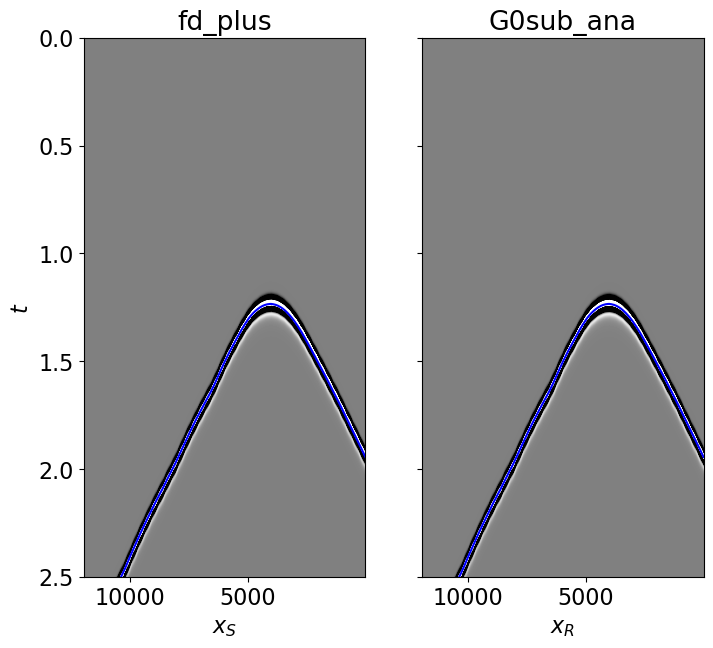

In [26]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 7))
axs[0].imshow(np.flipud(fd_plus), cmap='gray', vmin=-0.1*np.abs(fd_plus).max(), 
              vmax=0.1*np.abs(fd_plus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[0].set_title('fd_plus'), axs[0].set_xlabel(r'$x_S$'), axs[0].set_ylabel(r'$t$')
axs[0].plot(s[0], FirstVSs,'b')
axs[0].axis('tight')
axs[0].set_ylim(2.5, 0)
axs[1].imshow(G0sub_ana, cmap='gray', vmin=-0.1*np.abs(G0sub_ana).max(), 
              vmax=0.1*np.abs(G0sub_ana).max(), extent=(s[0,0], s[0,-1], t[-1], 0))
axs[1].set_title('G0sub_ana'), axs[1].set_xlabel(r'$x_R$')
axs[1].plot(s[0], FirstVSs,'b')
axs[1].axis('tight')
axs[1].set_ylim(2.5, 0);

(8996.031414511148, 3012.4324554347013, 5.998, -5.998)

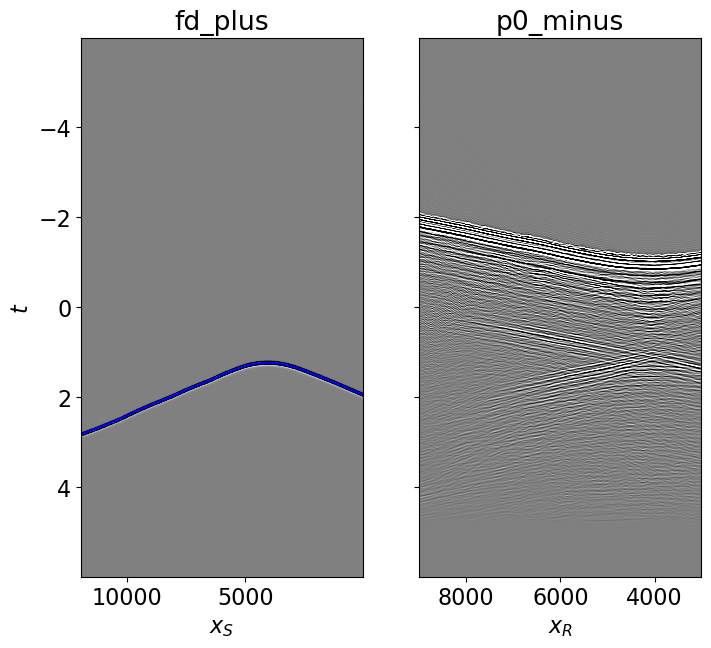

In [27]:
# Create data, adjoint and inverse focusing functions
p0_minus = Puop*fd_plus.ravel()
p0_minus = p0_minus.reshape((2*nt-1), nr).T
p0_minus_2 = np.concatenate((p0_minus, np.zeros((nr, 2*nt-1))))

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 7))
axs[0].imshow(np.flipud(fd_plus), cmap='gray', vmin=-0.1*np.abs(fd_plus).max(), 
              vmax=0.1*np.abs(fd_plus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[0].set_title('fd_plus'), axs[0].set_xlabel(r'$x_S$'), axs[0].set_ylabel(r'$t$')
axs[0].plot(s[0], FirstVSs,'b')
axs[0].axis('tight')
# axs[0].set_ylim(2.5, 0)
axs[1].imshow(p0_minus.T, cmap='gray', vmin=-0.1*np.abs(p0_minus).max(), 
              vmax=0.1*np.abs(p0_minus).max(), extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title('p0_minus'), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
# axs[1].set_ylim(2.5, 0);

(8996.031414511148, 3012.4324554347013, 5.998, -5.998)

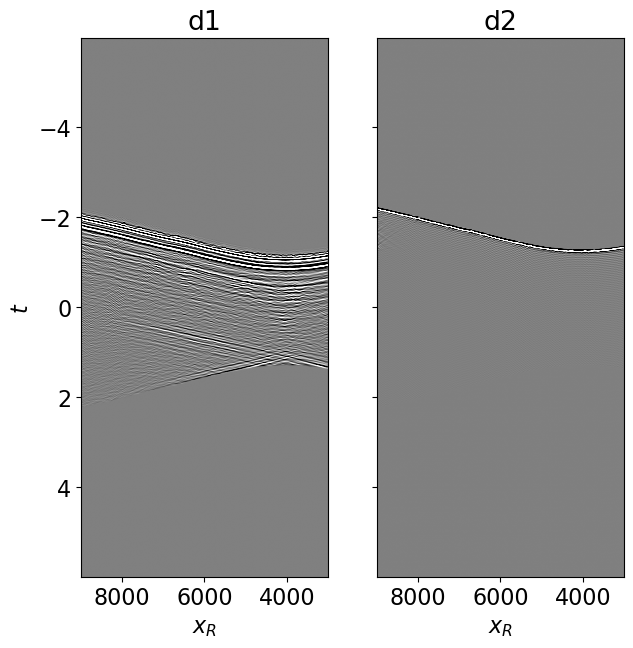

In [28]:
dinp = np.concatenate((np.zeros((2*nt-1, ns)), fd_plus), axis=0)
d = -Dop * dinp.ravel()
d = d.reshape(2*(2*nt-1), nr)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(7, 7))
axs[0].imshow(d[:(2*nt-1)], cmap='gray', vmin=-0.1*np.abs(d).max(), 
              vmax=0.1*np.abs(d).max(), extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title('d1'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
# axs[0].set_ylim(1, -1)
axs[1].imshow(d[(2*nt-1):], cmap='gray', vmin=-0.1*np.abs(d).max(), 
              vmax=0.1*np.abs(d).max(), extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title('d2'), axs[1].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[1].axis('tight')
# axs[1].set_ylim(1, -1);

In [29]:
%%time 
f1_adj = Mop.H*d.ravel()
f1_inv = lsqr(Mop, d.ravel(), iter_lim=10, show=True)[0]

f1_adj = f1_adj.reshape(2*(2*nt-1), ns)
f1_inv = f1_inv.reshape(2*(2*nt-1), ns)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 2879520 rows and 2879520 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.571e+10  2.571e+10    1.0e+00  8.2e-04
     1  0.00000e+00   2.246e+10  2.246e+10    8.7e-01  7.1e-01   4.4e+07  1.0e+00
     2  0.00000e+00   2.007e+10  2.007e+10    7.8e-01  2.2e-01   9.9e+07  3.2e+00
     3  0.00000e+00   1.861e+10  1.861e+10    7.2e-01  2.0e-01   1.2e+08  5.0e+00
     4  0.00000e+00   1.718e+10  1.718e+10    6.7e-01  1.3e-01   1.5e+08  7.5e+00
     5  0.00000e+00   1.627e+10  1.627e+10    6.3e-01  1.1e-01   1.7e+08  9.7e+00
     6  0.00000e+00   1.539e+10  1.539e+10    6.0e-01  1.0e-01   1.9e+08  1.2e+01
     7  0.00000e+00   1.464e+10  1.464e+10    5.7e-01  8.5e-02   2.1e+08  1.5e+01
     8  0.00000e+00   1.401e

Add initial guess to estimated focusing functions

In [30]:
f1_adj_tot = f1_adj + np.concatenate((np.zeros((2*nt-1, ns)),
                                      np.concatenate((np.fliplr(G0sub_ana.T).T, 
                                                      np.zeros((nt-1, ns))), axis=0)))
f1_inv_tot = f1_inv + np.concatenate((np.zeros((2*nt-1, ns)),
                                      fd_plus))

Estimate Green's functions

In [31]:
p_p_f_m = Pdop * f1_inv_tot[:(nt*2-1)].flatten()
p_m_f_p = Puop * f1_inv_tot[(nt*2-1):].flatten()

p_m_f_m = Rollop*Pu1op * f1_inv_tot[:(nt*2-1)].flatten()
p_p_f_p = Rollop*Pd1op * f1_inv_tot[(nt*2-1):].flatten()

In [32]:
p_p_f_m = p_p_f_m.reshape((2*nt-1), nr)
p_m_f_p = p_m_f_p.reshape((2*nt-1), nr)

p_m_f_m = p_m_f_m.reshape((2*nt-1), nr)
p_p_f_p = p_p_f_p.reshape((2*nt-1), nr)

In [33]:
g_adj = Gop*f1_adj_tot.flatten()
g_inv = Gop*f1_inv_tot.flatten()

g_adj = g_adj.reshape(2*(2*nt-1), nr)
g_inv = g_inv.reshape(2*(2*nt-1), nr)

Extract up and down focusing and Green's functions from model vectors

In [34]:
f1_adj_minus, f1_adj_plus =  f1_adj_tot[:(2*nt-1)].T, f1_adj_tot[(2*nt-1):].T
f1_inv_minus, f1_inv_plus =  f1_inv_tot[:(2*nt-1)].T, f1_inv_tot[(2*nt-1):].T

g_adj_minus, g_adj_plus =  -g_adj[:(2*nt-1)].T, np.fliplr(g_adj[(2*nt-1):].T)
g_inv_minus, g_inv_plus =  -g_inv[:(2*nt-1)].T, np.fliplr(g_inv[(2*nt-1):].T)

g_inv_tot = g_inv_minus + g_inv_plus

Visualization

(8996.031414511148, 6024.864910869403, 5.998, -5.998)

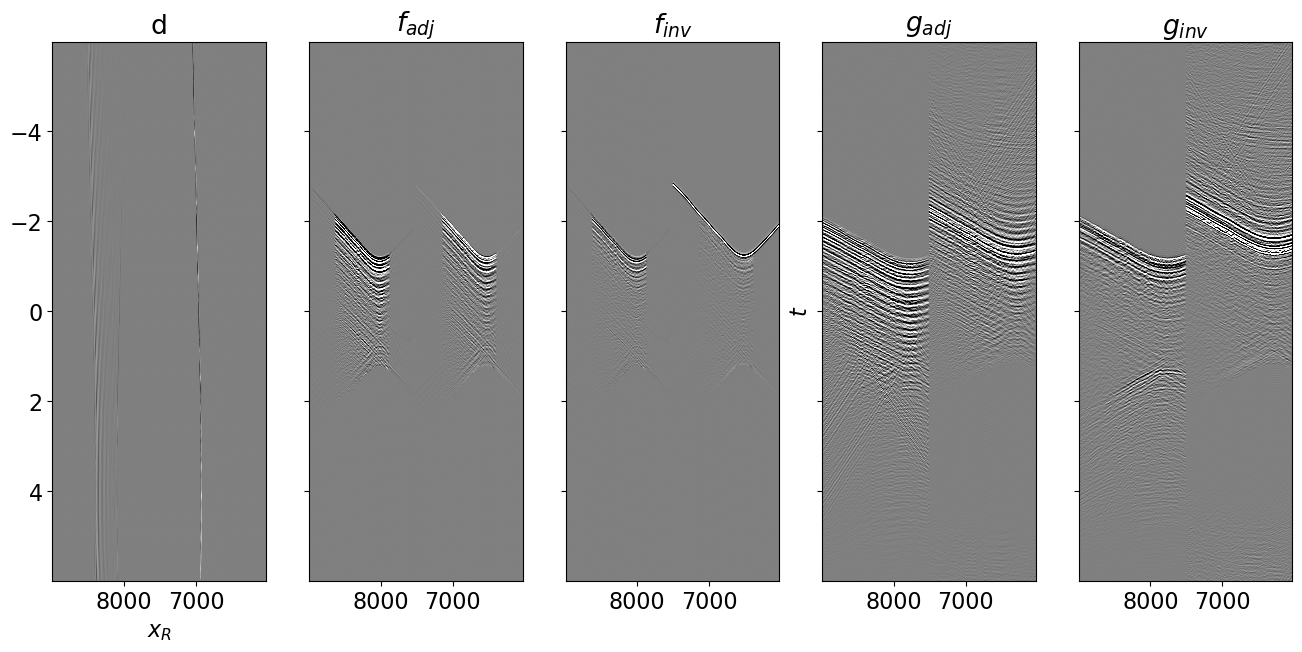

In [35]:
f1_adj_tot = np.concatenate((f1_adj_tot[:(2*nt-1)], f1_adj_tot[(2*nt-1):]), axis=1).T
f1_inv_tot = np.concatenate((f1_inv_tot[:(2*nt-1)], f1_inv_tot[(2*nt-1):]), axis=1).T
g_adj = np.concatenate((g_adj[:(2*nt-1)], g_adj[(2*nt-1):]), axis=1).T
g_inv = np.concatenate((g_inv[:(2*nt-1)], g_inv[(2*nt-1):]), axis=1).T

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(16, 7))
axs[0].imshow(d.T, cmap='gray', vmin=-0.1*np.abs(d).max(), 
              vmax=0.1*np.abs(d).max(), extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[0].set_title('d'), axs[0].set_xlabel(r'$x_R$'), axs[3].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[1].imshow(f1_adj_tot.T, cmap='gray', vmin=-0.1*np.abs(f1_adj_tot).max(), 
              vmax=0.1*np.abs(f1_adj_tot).max(), extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f_{adj}$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[2].imshow(f1_inv_tot.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_tot).max(), 
              vmax=0.1*np.abs(f1_inv_tot).max(), extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[3].imshow(g_adj.T, cmap='gray', vmin=-0.1*np.abs(g_adj).max(), 
              vmax=0.1*np.abs(g_adj).max(), extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[3].set_title(r'$g_{adj}$'), axs[0].set_xlabel(r'$x_R$')
axs[3].axis('tight')
axs[4].imshow(g_inv.T, cmap='gray', vmin=-0.1*np.abs(g_inv).max(), 
              vmax=0.1*np.abs(g_inv).max(), extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[4].set_title(r'$g_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[4].axis('tight')
# axs[4].set_ylim(1.5, -1.5);

(11955.435010428777, 5.827304162345612, 5.998, -5.998)

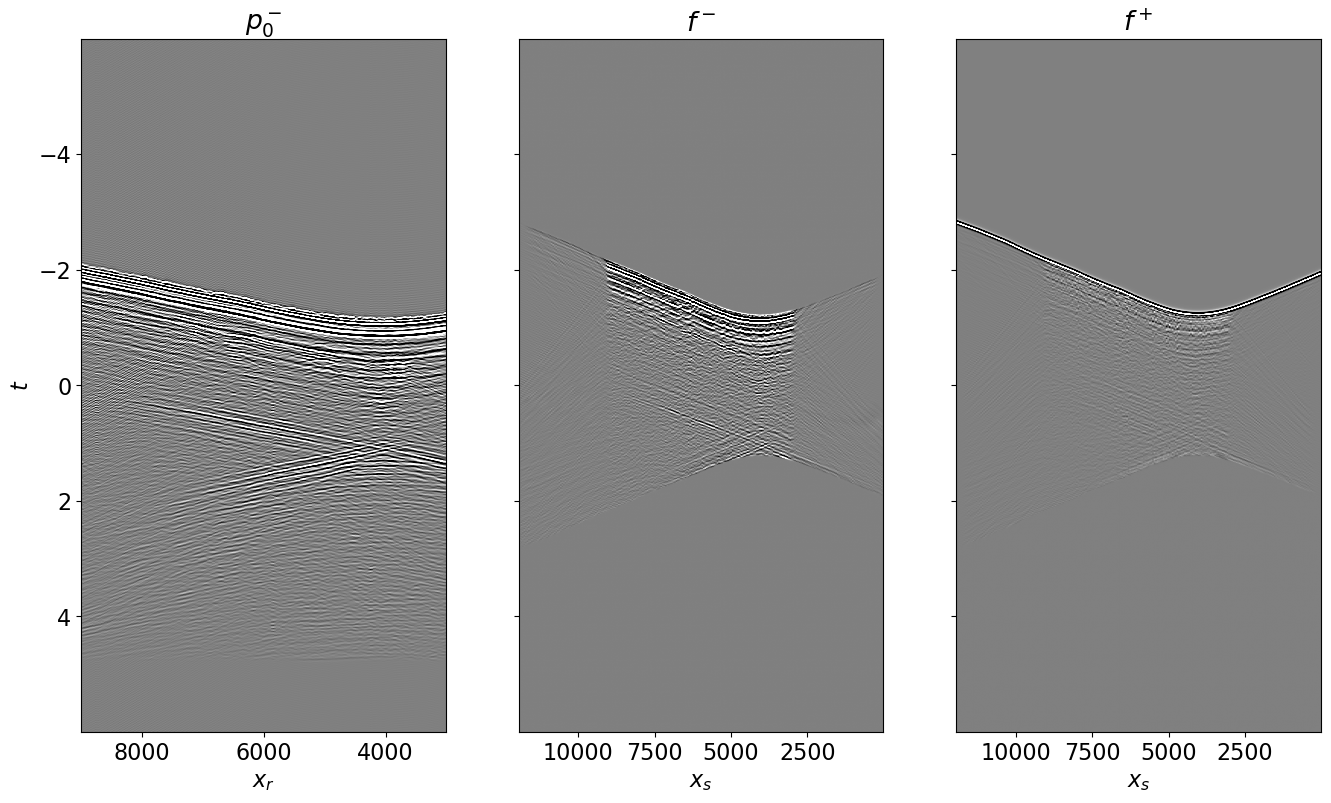

In [36]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-0.1*np.abs(p0_minus).max(), 
              vmax=0.1*np.abs(p0_minus).max(), extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_r$'), axs[0].set_ylabel(r'$t$')
# axs[0].plot(r[0], FirstVSs,'b'),axs[0].plot(r[0], -FirstVSs,'b')
axs[0].axis('tight')
# axs[0].set_ylim(1, -1);
axs[1].imshow(f1_inv_minus.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_minus).max(), 
              vmax=0.1*np.abs(f1_inv_minus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[1].set_xlabel(r'$x_s$')
# axs[1].plot(r[0], FirstVSs,'b'),axs[1].plot(r[0], -FirstVSs,'b')
axs[1].axis('tight')
# axs[1].set_ylim(1, -1);
axs[2].imshow(f1_inv_plus.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_plus).max(), 
              vmax=0.1*np.abs(f1_inv_plus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[2].set_xlabel(r'$x_s$')
# axs[2].plot(r[0], FirstVSs,'b'),axs[2].plot(r[0], -FirstVSs,'b')
axs[2].axis('tight')
# axs[2].set_ylim(1, -1);

(11955.435010428777, 5.827304162345612, 5.998, -5.998)

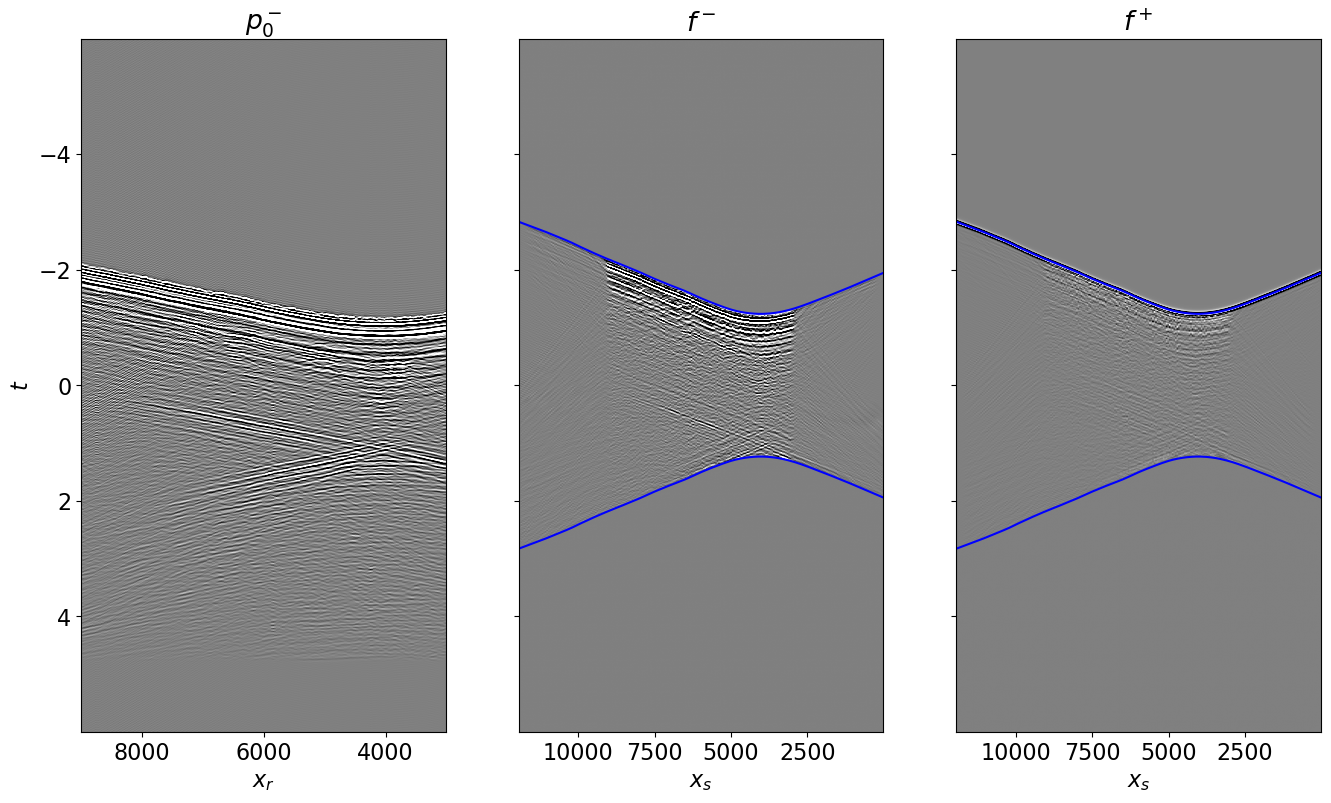

In [37]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-0.1*np.abs(p0_minus).max(), 
              vmax=0.1*np.abs(p0_minus).max(), extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_r$'), axs[0].set_ylabel(r'$t$')
# axs[0].plot(r[0], FirstVSs,'b'),axs[0].plot(r[0], -FirstVSs,'b')
axs[0].axis('tight')
# axs[0].set_ylim(0, -3);
axs[1].imshow(f1_inv_minus.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_minus).max(), 
              vmax=0.1*np.abs(f1_inv_minus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[1].set_xlabel(r'$x_s$')
axs[1].plot(s[0], FirstVSs,'b'),axs[1].plot(s[0], -FirstVSs,'b')
axs[1].axis('tight')
# axs[1].set_ylim(0, -3);
axs[2].imshow(f1_inv_plus.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_plus).max(), 
              vmax=0.1*np.abs(f1_inv_plus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[2].set_xlabel(r'$x_s$')
axs[2].plot(s[0], FirstVSs,'b'),axs[2].plot(s[0], -FirstVSs,'b')
axs[2].axis('tight')
# axs[2].set_ylim(0, -3);

(11955.435010428777, 5.827304162345612, 5.998, -5.998)

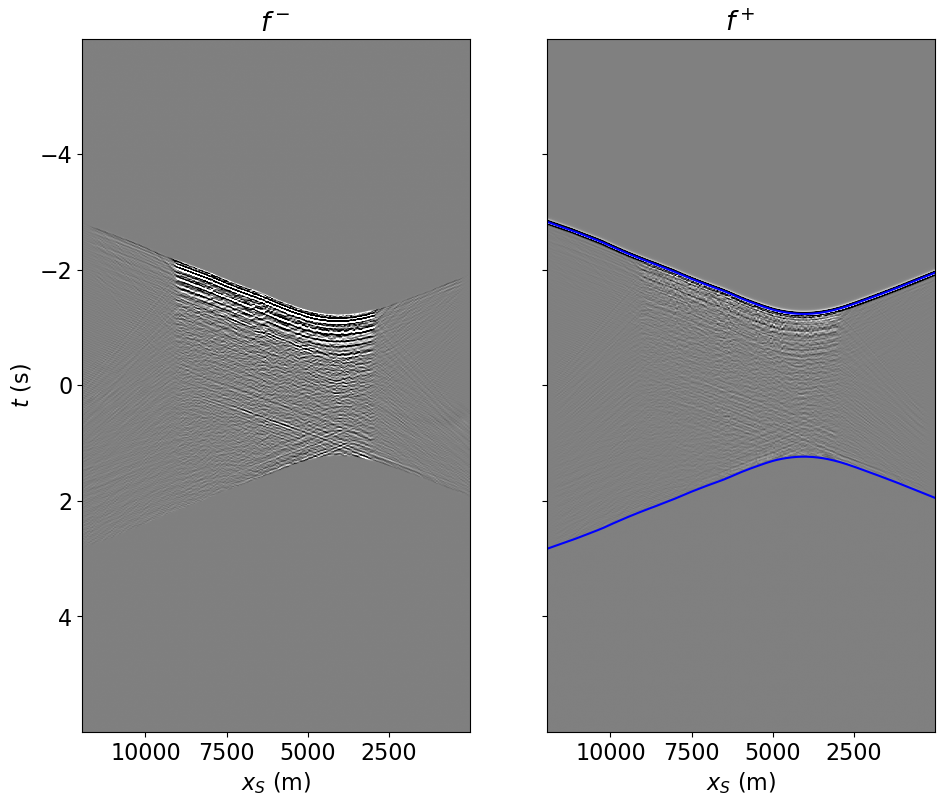

In [38]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(11, 9))
axs[0].imshow(f1_inv_minus.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_minus).max(), 
              vmax=0.1*np.abs(f1_inv_minus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_S$ (m)'), axs[0].set_ylabel(r'$t$ (s)')
# axs[0].plot(r[0], directVS,'b'),axs[0].plot(r[0], -directVS,'b')
axs[0].axis('tight')
# axs[0].set_ylim(2, -2);
axs[1].imshow(f1_inv_plus.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_plus).max(), 
              vmax=0.1*np.abs(f1_inv_plus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^+$'), axs[1].set_xlabel(r'$x_S$ (m)')
axs[1].plot(s[0], FirstVSs,'b'),axs[1].plot(s[0], -FirstVSs,'b')
axs[1].axis('tight')
# axs[1].set_ylim(2, -2);
# fig.savefig('f_Mar.eps', format='eps', dpi=300)

(8996.031414511148, 3012.4324554347013, 5.998, -5.998)

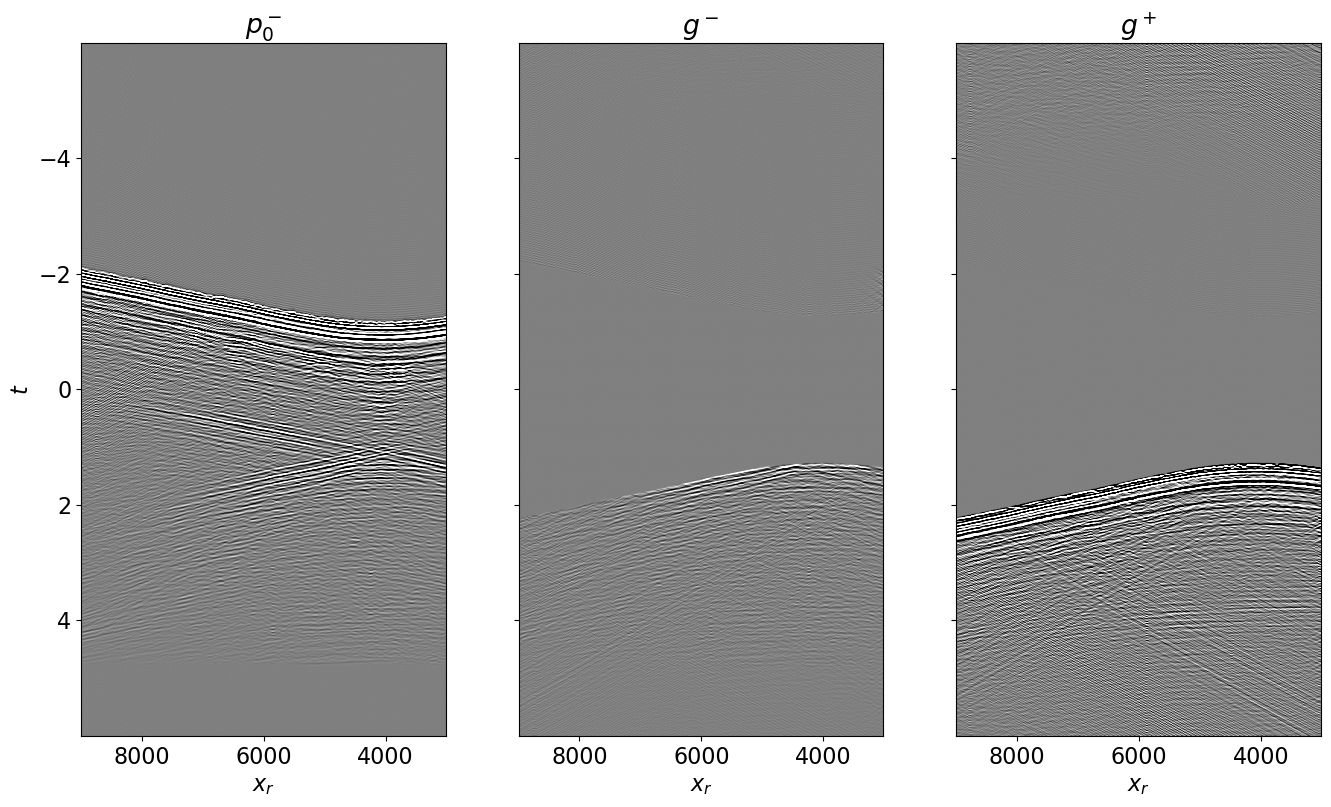

In [39]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-0.1*np.abs(p0_minus).max(), 
              vmax=0.1*np.abs(p0_minus).max(), extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_r$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
# axs[0].set_ylim(2, 1);
axs[1].imshow((1-wr.T) * g_inv_minus.T, cmap='gray', vmin=-0.1*np.abs(g_inv_plus+g_inv_minus).max(), 
              vmax= 0.1*np.abs(g_inv_plus+g_inv_minus).max(), extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$'), axs[1].set_xlabel(r'$x_r$')
axs[1].axis('tight')
# axs[1].set_ylim(2, 1);
axs[2].imshow(-(1-wr.T) * g_inv_plus.T, cmap='gray', vmin=-0.1*np.abs(g_inv_plus+g_inv_minus).max(), 
              vmax=0.1*np.abs(g_inv_plus+g_inv_minus).max(), extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$'), axs[2].set_xlabel(r'$x_r$')
# axs[2].plot(r[0], FirstVSr,'b'),ax[0].plot(r[0], -FirstVSr,'b')
axs[2].axis('tight')
# axs[2].set_ylim(2, 1);

In [40]:
G0 = np.zeros((nt, nr))
G0 = directwave(wav[wav_c-wav_c:wav_c+wav_c], FirstVSr, nt, dt, nfft=2**11)

In [41]:
g_plus = (1-wr.T) * g_inv_plus.T
g_plus1 = g_plus[nt-1:,:]

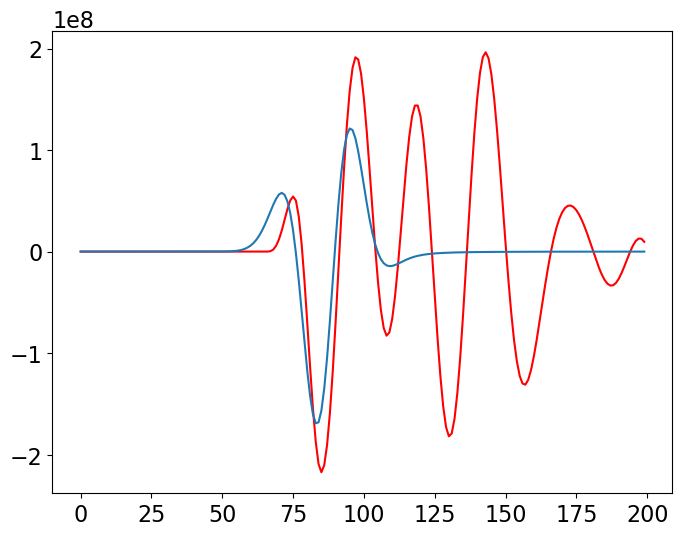

In [42]:
plt.plot(g_plus1[700:900,nr//2],'r')
plt.plot(-G0[700:900,nr//2]*3e6)